<a href="https://colab.research.google.com/github/soyoonjeong/deeplearning_from_scratch/blob/main/ch4_word2vec_%EC%86%8D%EB%8F%84_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Embedding 계층은 단어의 분산 표현을 담고 있으며, 순전파 시 지정한 단어 id의 벡터를 추출
- word2vec은 어휘 수의 증가에 비례하여 계산량이 증가하므로 근사치로 계산하는 빠른 기법을 사용하면 좋음
- 네거티브 샘플링은 부정적 예를 몇 개 샘플링하는 기법으로 이를 이용하면 다중 분류를 이진 분류처럼 취급할 수 있음
- word2vec으로 얻은 단어의 분산 표현에는 단어의 의미가 녹아들어 있으며, 비슷한 맥락에서 사용되는 단어는 단어 벡터 공간에서 가까이 위치함
- word2vec의 단어의 분산 표현을 이용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있게 됨
- word2vec은 전이 학습 측면에서 특히 중요하며, 그 단어의 분산 표현은 다양한 자연어 처리 작업에 이용할 수 있음음

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
%cd /content/drive/MyDrive

/content/drive/MyDrive


3장 word2vec 모델(단순 2층 신경망)

문제점) 말뭉치에 포함된 어휘 수가 많아지면 계산량도 커짐  <br>
- 입력층의 원핫 표현과 가중치 행렬 Win의 곱 계산 
- 은닉층과 가중치 행렬 Wout의 곱 및 Softmax 계층의 계산 

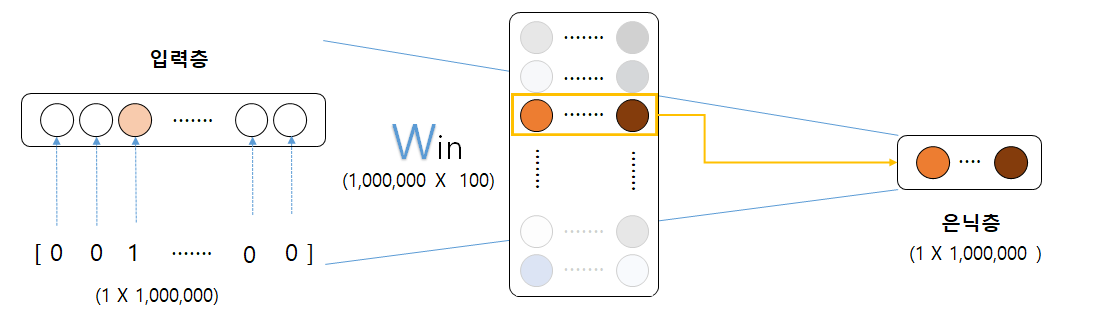

해결책) word2vec의 속도 개선 <br>
- Embedding 계층 도입
- 네거티브 샘플링 (새로운 손실함수) 도입 

# word2vec 개선 1 : 임베딩 계층 도입 

## Embedding 계층

문제점) 원핫표현 => 100만 개의 어휘를 담은 말뭉치가 있다면, 단어의 원핫 표현도 100만 차원이 됨 

해결책) 가중치 매개변수로부터 단어 ID에 해당하는 행 벡터를 추출하는 계층 만들어 MatMul 계층 대신해 사용 <BR>
=> Embedding 계층에 단어 임베딩(분산 표현)을 저장 <BR>
=> 메모리 사용량 줄이고 계산 생략략

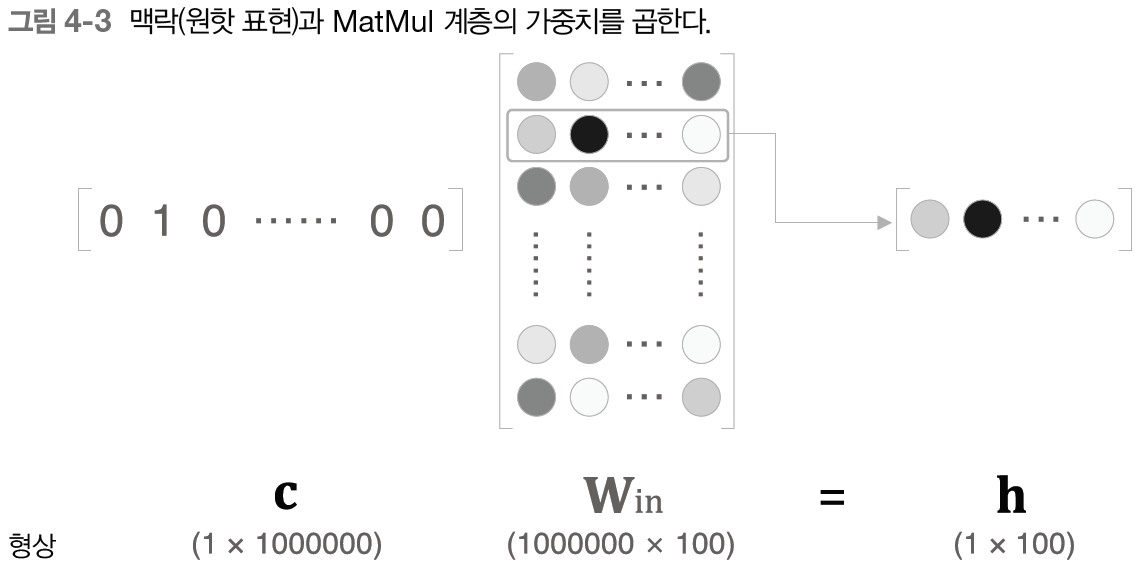

## Embedding 계층 구현

In [ ]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx): # 순전파 : 가중치 W의 특정 행을 추출
    W, =  self.params
    self.idx = idx
    out = W[idx] # idx에 해당하는 행만 추출 
    return out
  
  def backward(self, dout): # 역전파 : 앞 층으로부터 전해진 기울기를 가중치 기울기 dW의 특정 행에 저장
    dW,  = self.grads
    dW[...] = 0
    # dW[self.idx] = dout # 중복 문제를 해결하기 위해 '할당'을 하면 안됨 (덮어쓰기)

    # for i, word_id in enumerate(self.idx):
    #   dW[word_id] += dout[i]
    np.add_at(dW, self.idx, dout) # 반복문 없이 numpy 연산 

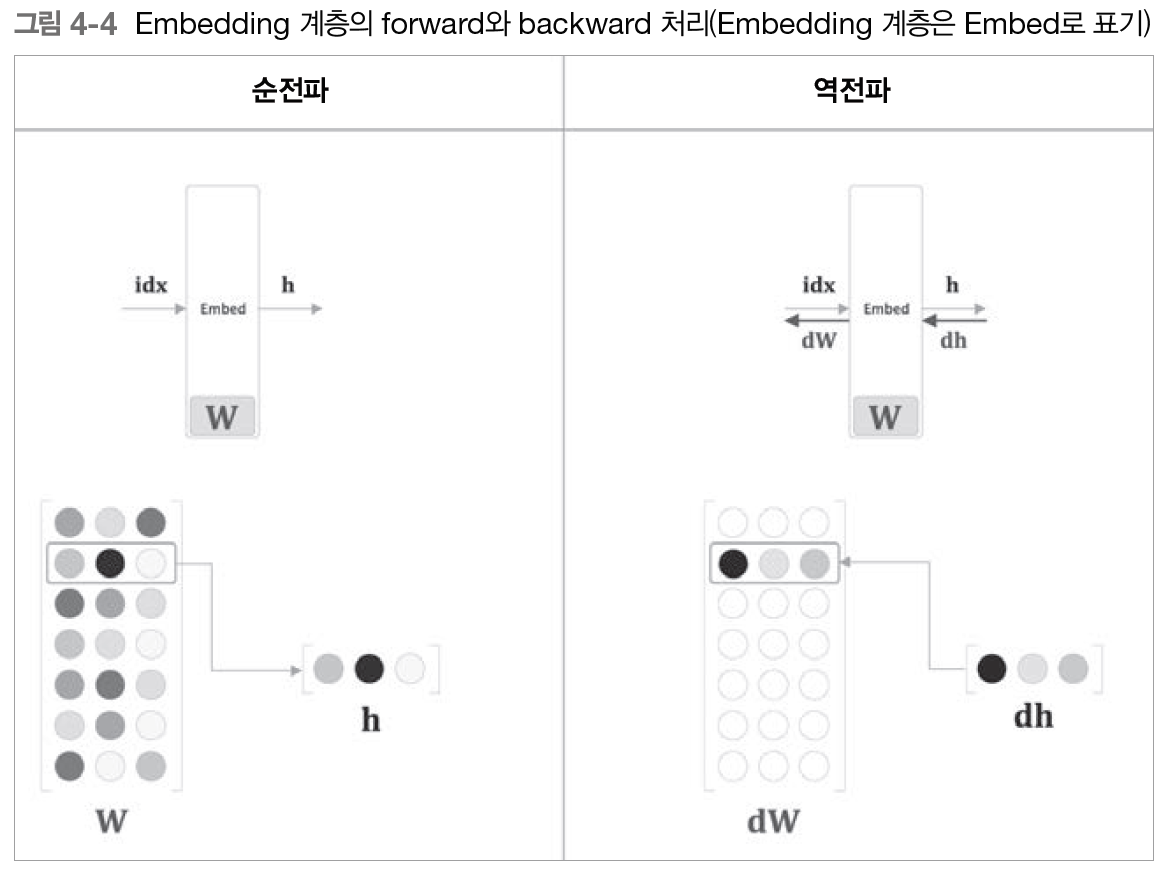

# word2vec 개선 : 네거티브 샘플링 도입

## 은닉층 이후 계산의 문제점 

- 은닉층의 뉴런과 가중치 행렬의 곱
- Softmax 계층의 계산 

## 다중 분류에서 이진 분류로 

- 다중 분류 : 맥락이 'you'와 'goodbye'일 때 타깃 단어는 무엇입니까? 로 학습
- 이진 분류 : 맥락이 'you'와 'goodbye'일 때 타깃 단어는 'say'입니까? 로 학습 <br>
=> 출력 측의 가중치 행렬에서 타깃 단어에 해당하는 열(단어 벡터)만을 추출 -> 추출된 벡터와 은닉층 뉴런과의 내적 계산 <br>
=> 모든 단어를 대상으로 계산 수행 x -> 단어 하나에 주목하여 그 점수만을 계산 

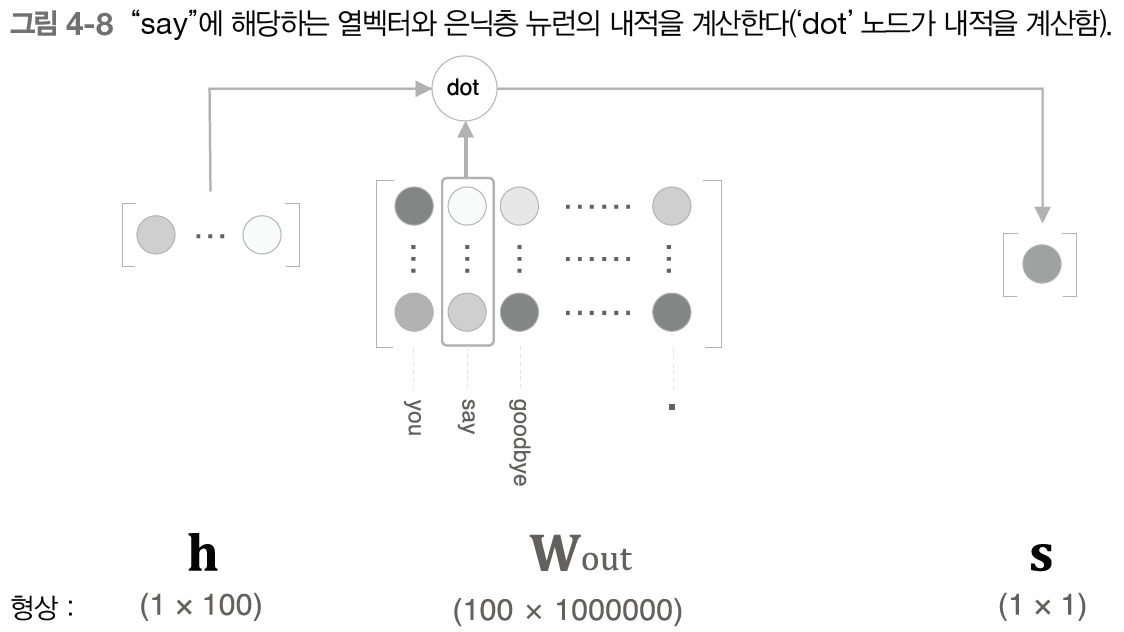

## 시그모이드 함수와 교차 엔트로피 오차 

이진 분류 문제로 신경망을 풀려면 점수에 **시그모이드 함수**를 적용해 확률로 변환하고, 손실함수로 **교차 엔트로피 오차**를 사용 <br>
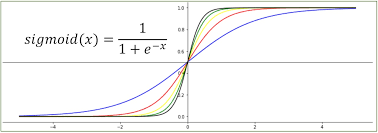 <br>
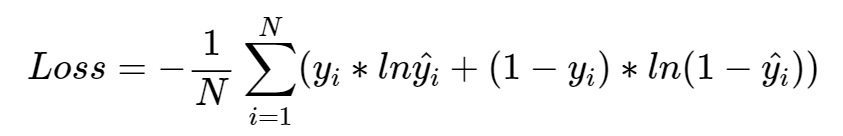

y-t라는 오차가 앞 계층으로 흘러가므로 오차가 크면 크게 학습하고 오차가 작으면 작게 학습하게 됨 <br>
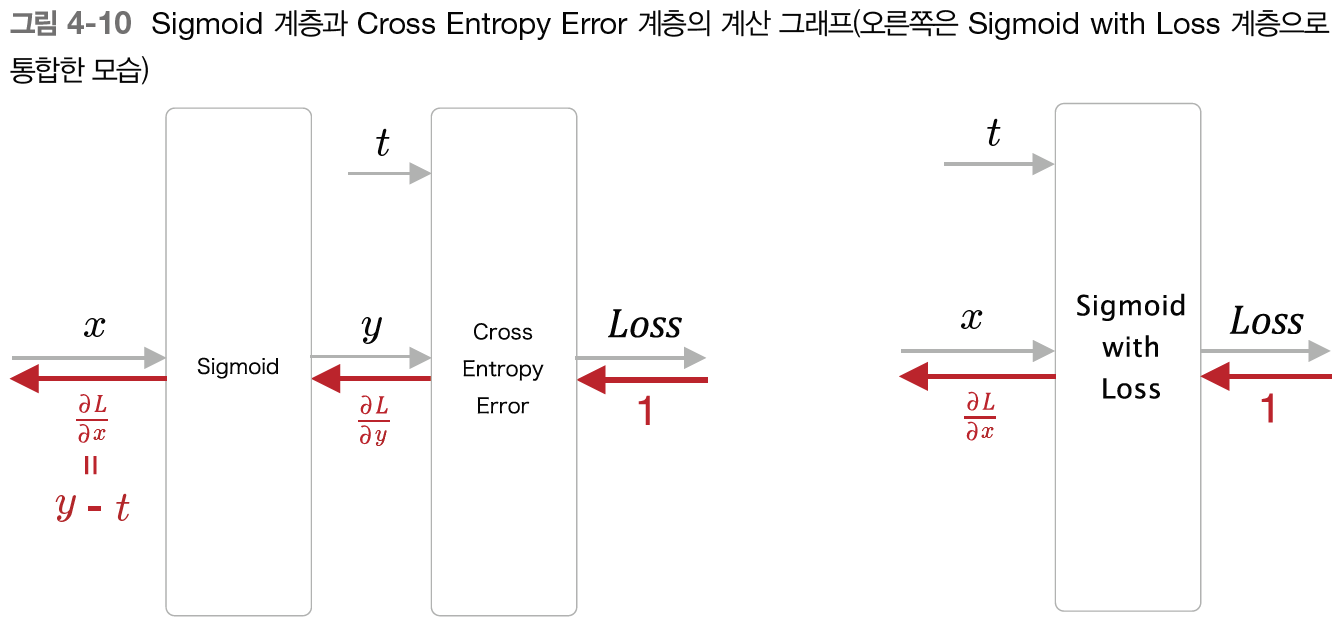

## 다중 분류에서 이진 분류로 (구현)

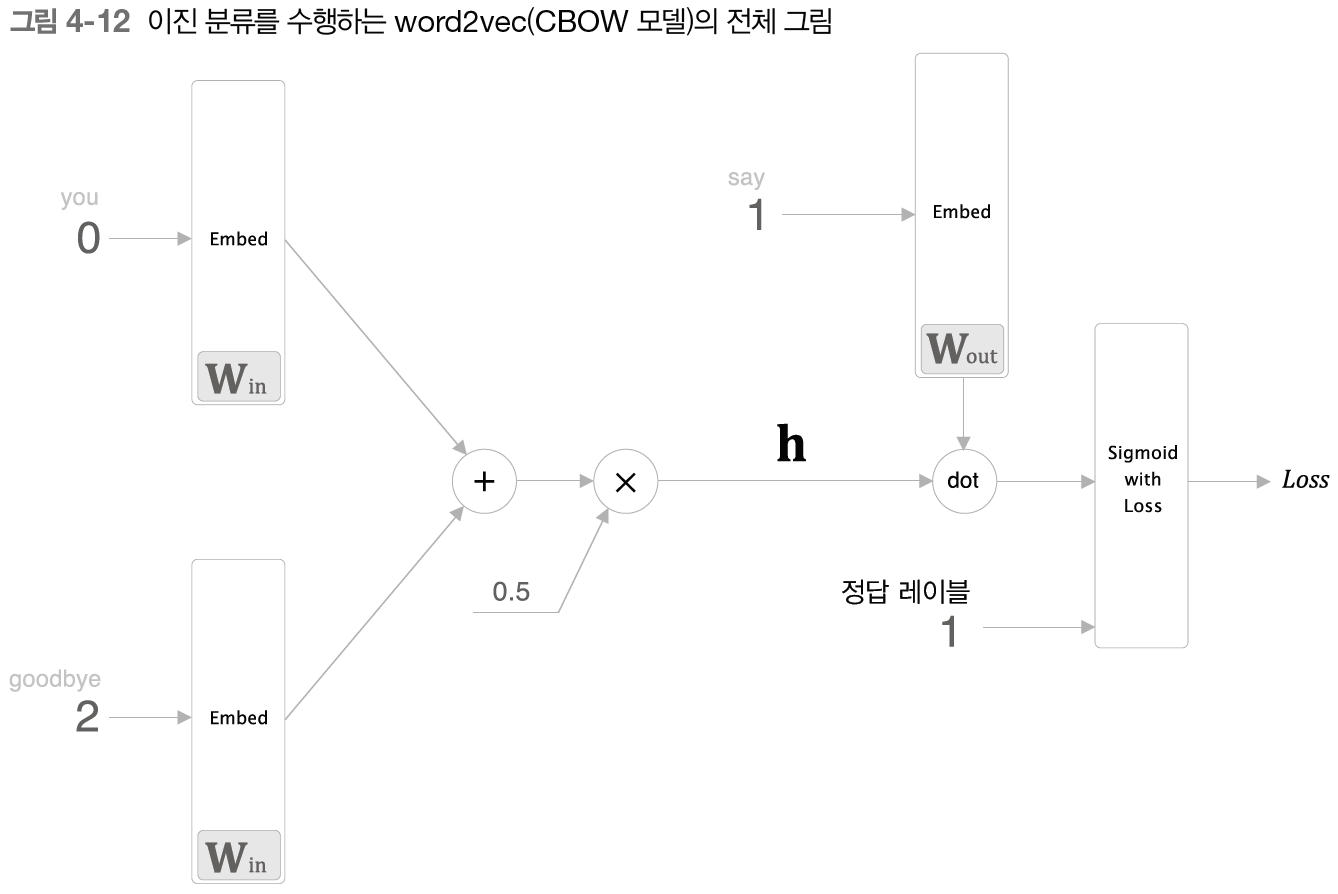

In [ ]:
# Embedding 계층과 dot 연산(내적) 처리를 합친 계층 => Embedding Dot 계층 도입

class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None

  def forward(self, h, idx):
    target_W = self.embed.forward(idx)
    out = np.sum(target_W * h, axis = 1) # 내적 

    self.cache = (h, target_W) # 순전파 시 계산 결과 잠시 유지 
    return out 

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)

    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

## 네거티브 샘플링 

긍정적인 예에 대해서는 sigmoid 계층의 출력이 1에 가깝도록 <br>
부정적인 예에 대해서는 sigmoid 계층의 출력이 0에 가깝도록 만드는 것이 목표 <br>
=> **네거티브 샘플링**을 이용하여 적은 수의 부정적 예를 샘플링해 사용 (모든 수는 감당 x)<br>
=> 긍정적 예를 타깃으로 한 경우의 손실과 부정적 예를 샘플링하여 타깃으로 한 경우의 손실을 더하여 최종 손실로 함함

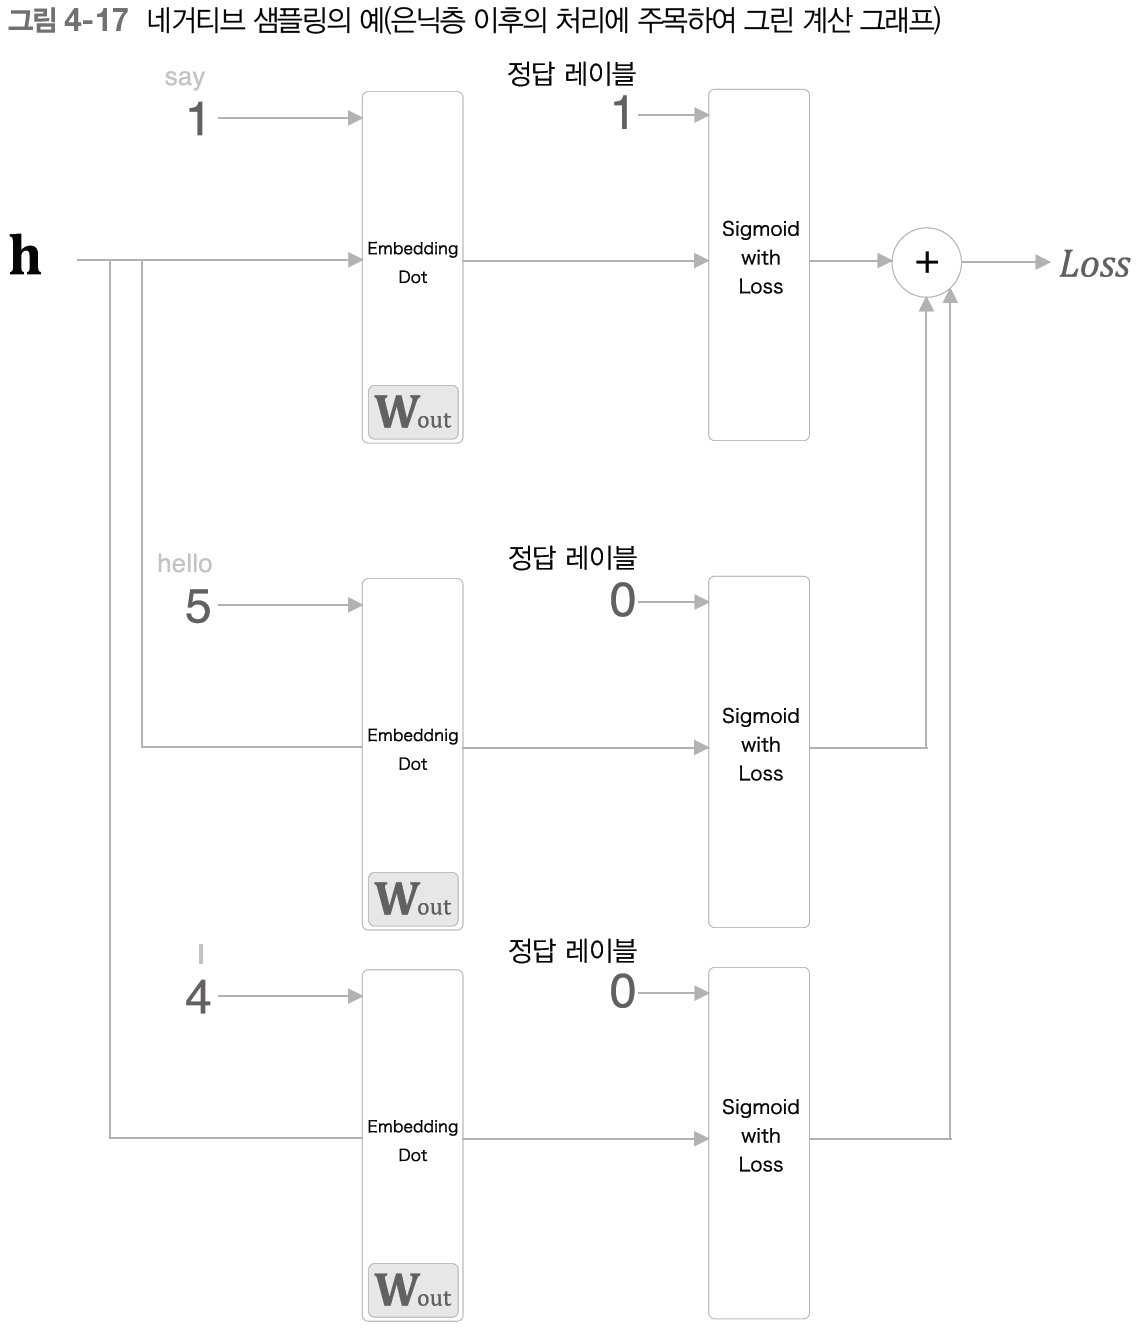

## 네거티브 샘플링의 샘플링 기법 

말뭉치에서 자주 등장하는 단어를 많이 추출하고 드물게 등장하는 단어를 적게 추출 <br>=> 단어별 출현 횟수 확률분포에 따라 샘플링 수행 

In [ ]:
words = ['you','say','goodbye','i','hello','.']
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p = p) # 인수 p에 확률분포를 담으면 확률분포대로 샘플링 

'you'

출현 확률이 낮은 단어를 버리지 않기 위해 0.75 제곱함 => 확률이 낮은 단어의 확률을 살짝 높힐 수 있음 <br>
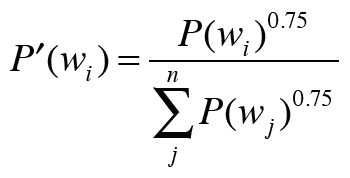

## 네거티브 샘플링 구현 

In [ ]:
import collections
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            # GPU(cupy)로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample


In [ ]:
from common.layers import Embedding, SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # 부정적 예 개수 : sample_size + 긍정적 예 개수 : 1
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

# 개선판 word2vec 학습 

## CBOW 모델 구현 

In [ ]:
from common.np import * 
from common.layers import Embedding

class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size

    # 가중치 초기화 
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')

    # 레이어 생성
    self.in_layers = []
    for i in range(2* window_size):
      layer = Embedding(W_in)
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power = 0.75, sample_size = 5)

    # 모든 가중치와 기울기를 배열에 모음 
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1/ len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
    return loss

  def backward(self, dout = 1):
    dout = self.ns_loss.backward(dout)
    dout *= 1/ len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

## CBOW 모델 학습 코드 

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.13
| 에폭 1 |  반복 81 / 9295 | 시간 6[s] | 손실 4.06
| 에폭 1 |  반복 101 / 9295 | 시간 8[s] | 손실 3.94
| 에폭 1 |  반복 121 / 9295 | 시간 10[s] | 손실 3.80
| 에폭 1 |  반복 141 / 9295 | 시간 11[s] | 손실 3.62
| 에폭 1 |  반복 161 / 9295 | 시간 12[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 14[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 15[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 16[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 18[s] | 손실 3.07
| 에폭 1 |  반복 261 / 9295 | 시간 19[s] | 손실 3.03
| 에폭 1 |  반복 281 / 9295 | 시간 21[s] | 손실 2.95
| 에폭 1 |  반복 301 / 9295 | 시간 23[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 25[s] | 손실 2.89
| 에폭 1 |  반복 341 / 9295 | 시간 26[s] | 손실 2.84
| 에폭 1 |  반복 361 / 9295 | 시간 28[s] | 손실 2.84
| 에폭 1 |  반복 381 / 9295 | 시간 29[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 30[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 32[s] | 손실 2.77
| 에폭 1 |  반복 441 / 929

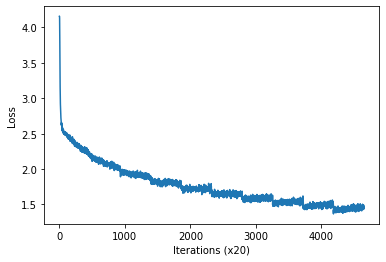

In [ ]:
import numpy as np
from common import config
# config.GPU = True
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼 파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
# if config.GPU:
#     contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

## CBOW 모델 평가 

In [2]:
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['you','year','car','toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top = 5)


[query] you
 we: 0.75244140625
 i: 0.6767578125
 they: 0.59619140625
 weird: 0.591796875
 your: 0.58935546875

[query] year
 month: 0.85107421875
 summer: 0.79931640625
 week: 0.7841796875
 spring: 0.72998046875
 decade: 0.67333984375

[query] car
 luxury: 0.60693359375
 auto: 0.60302734375
 cars: 0.5888671875
 window: 0.58203125
 truck: 0.57861328125

[query] toyota
 nec: 0.67041015625
 seita: 0.65771484375
 nissan: 0.64306640625
 marathon: 0.60888671875
 weyerhaeuser: 0.60791015625


In [3]:
from common.util import analogy

analogy('king','man','queen', word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 a.m: 5.8203125
 woman: 5.39453125
 toxin: 5.0078125
 mother: 5.00390625
 husband: 4.98828125


# word2vec 남은 주제 

## word2vec을 사용한 애플리케이션의 예예

**전이학습** => 큰 말뭉치(위키백과 등)으로 학습을 끝낸 후, 그 분산 표현을 각자의 작업에 이용
- 단어의 분산 표현은 단어를 고정 길이 벡터로 변환
- 문장도 단어의 분산 표현을 이용하여 고정 길이 벡터로 변환
  - bag-of-words : 문장의 각 단어를 분산표현으로 변환해 그 합을 구함 (순서x)
  - 순환 신경망을 이용 
- 자연어를 벡터로 변환함으로써 일반적인 머신러닝 시스템의 틀에서 원하는 답을 출력하는 것이 가능 

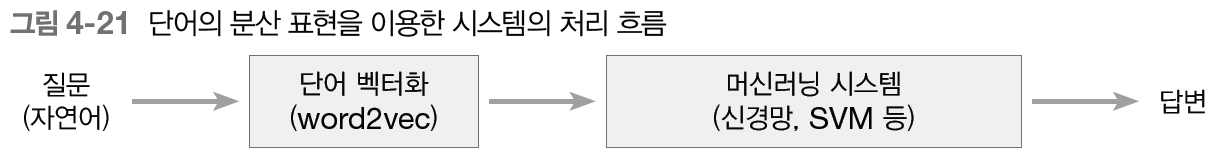

## 단어 벡터 평가 방법 

- 단어의 분산 표현을 학습하고, 그 분산 표현을 사용하여 또 하나의 머신 러닝 시스템을 학습 
- 단어의 분산 표현의 우수성은 단어의 '유사성'이나 '유추 문제'를 활용해 평가
- 모델에 따라 정확도가 다름
- 일반적으로 말뭉치가 클수록 결과가 좋음
- 단어 벡터 차원 수는 적당한 크기가 좋음 